# Deep Learning in JAX

This notebook provides an introduction to basic Deep Supervised Learning using [JAX](https://jax.readthedocs.io/en/latest/). In particular, we will cover the MNIST classification problem -- one of the first big success stories in ML.

Our goal is to become familiar with the typical pipelines of Deep Learning in JAX. This includes:

* building models: shallow and deep networks with nonlinear activations, fully-connected and convolutional layers, etc;
* defining cost functions and figure-of-merit functions which test the model accuracy;
* computing derivatives of model parameters;
* understanding the optimizer pipeline and how to update the model parameters.

## Classification Problems

The "harmonic oscillator" of Deep Learning is the MNIST problem.

### The MNIST Dataset

The MNIST classification problem is one of the classical ML problems for learning classification on high-dimensional data with a fairly sizeable number of examples. Yann LeCun and collaborators collected and processed  70 000  handwritten digits (60 000 are used for training and 10 000 for testing) to produce what became known as one of the most widely used datasets in ML: the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). Each handwritten digit comes in a grayscale square image in the shape of a  28×28  pixel grid. Every pixel takes a value in the range  [0, 255], representing  256  nuances of the gray color from black to white. The problem of image classification finds applications in a wide range of fields and is important for numerous industry applications of ML: there have exists a number of much more challenging datasets, such as [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) or [ImageNet](http://www.image-net.org/).


### Data Preprocesssing

The first two codeblocks below download the MNIST dataset from the web, and preprocess the MNIST data. In particular, the data are separated into a training set, and a test set, and the labels are encoded in one-hot form.

In [1]:
##### download MNIST data and store it in under directory _DATA

import array
import gzip
import os
from os import path
import struct
import urllib.request

import numpy as np


# path to data directory
_DATA = "/tmp/jax_example_data/"


def _download(url, filename):
    """Download a url to a file in the JAX data temp directory."""
    if not path.exists(_DATA):
        os.makedirs(_DATA)
    out_file = path.join(_DATA, filename)
    if not path.isfile(out_file):
        urllib.request.urlretrieve(url, out_file)
        print("downloaded {} to {}".format(url, _DATA))


def _partial_flatten(x):
    """Flatten all but the first dimension of an ndarray."""
    return np.reshape(x, (x.shape[0], -1))


def _one_hot(x, k, dtype=np.float32):
    """Create a one-hot encoding of x of size k."""
    return np.array(x[:, None] == np.arange(k), dtype)


def mnist_raw():
    """Download and parse the raw MNIST dataset."""
    # CVDF mirror of http://yann.lecun.com/exdb/mnist/
    base_url = "https://storage.googleapis.com/cvdf-datasets/mnist/"

    def parse_labels(filename):
        with gzip.open(filename, "rb") as fh:
            _ = struct.unpack(">II", fh.read(8))
            return np.array(array.array("B", fh.read()), dtype=np.uint8)

    def parse_images(filename):
        with gzip.open(filename, "rb") as fh:
            _, num_data, rows, cols = struct.unpack(">IIII", fh.read(16))
            return np.array(array.array("B", fh.read()),
                          dtype=np.uint8).reshape(num_data, rows, cols)

    for filename in ["train-images-idx3-ubyte.gz", "train-labels-idx1-ubyte.gz",
                   "t10k-images-idx3-ubyte.gz", "t10k-labels-idx1-ubyte.gz"]:
        _download(base_url + filename, filename)

    train_images = parse_images(path.join(_DATA, "train-images-idx3-ubyte.gz"))
    train_labels = parse_labels(path.join(_DATA, "train-labels-idx1-ubyte.gz"))
    test_images = parse_images(path.join(_DATA, "t10k-images-idx3-ubyte.gz"))
    test_labels = parse_labels(path.join(_DATA, "t10k-labels-idx1-ubyte.gz"))

    return train_images, train_labels, test_images, test_labels


def mnist(permute_train=False):
    """Download, parse and process MNIST data to unit scale and one-hot labels."""
    train_images, train_labels, test_images, test_labels = mnist_raw()

    train_images = _partial_flatten(train_images) / np.float32(255.)
    test_images = _partial_flatten(test_images) / np.float32(255.)
    train_labels = _one_hot(train_labels, 10)
    test_labels = _one_hot(test_labels, 10)

    if permute_train:
        perm = np.random.RandomState(0).permutation(train_images.shape[0])
        train_images = train_images[perm]
        train_labels = train_labels[perm]

    return train_images, train_labels, test_images, test_labels


#### Minibatches

Now that we've written the functions to download and preprocess the MNIST dataset, let's prepare it for training. Since we'll be using some variant of SGD (e.g., ADAM, etc.), we need to feed data into our machine learning model (e.g., a DNN) in random minibatches. 

The function `data_stream` creates a python generator which returns one minibatch of the randomized training set at a time, until all training datapoints are exhausted. To do this efficiently, `data_stream()` defines a python generator. Generators are functions containing loops which `yield` a result one at a time until the loop is exhausted, rather than `return` the output. 

If you're not familiar with generators, explore carefully the code below first. Make sure to explore the effect of the `while`-loop statement which is currently commented out. What is the purpose of having generators? What are generetors good/useful for? Explore the `data_stream()` generator below by printing a few small minibatches. 

In [2]:
def my_generator():
    #while True:
        for j in range(10):
            yield j
            
gen = my_generator()
print(gen) # shows a generator object

print('\nfirst loop:\n')   

# call generator
for i in range(4):
    print(i, next(gen) )
    
print('\nsecond loop:\n')    
    
for i in range(10):
    print(i, next(gen) )

<generator object my_generator at 0x7fe594e767d0>

first loop:

0 0
1 1
2 2
3 3

second loop:

0 4
1 5
2 6
3 7
4 8
5 9


StopIteration: 

In [3]:
### define minibatches

# fix seed
seed=0
np.random.seed(seed)

##### define data variables and the minibatch generator
# load MNIST data
train_images, train_labels, test_images, test_labels = mnist()

print('\ntrain data: image shape: {}, label shape: {}.'.format(train_images.shape, train_labels.shape ))
print('test data : image shape: {}, label shape: {}.\n'.format(test_images.shape, test_labels.shape ))


# size of a single minibatch
batch_size=128 
# size of the trining set
num_train = train_images.shape[0] 
# define number of complete minibatches (data size need not be muptiple of batch_size)
num_complete_batches, leftover = divmod(num_train, batch_size)
# total number of minibatches is the smallest integer to fit all minibatches in the dataset
num_batches = num_complete_batches + bool(leftover)


def data_stream():
    """
    This function defines a generator which produces random batches of data, one at a time.
    
    """
    rng = np.random.RandomState(0)
    while True:
        perm = rng.permutation(num_train) # compute a random permutation
        for i in range(num_batches):
            batch_idx = perm[i * batch_size:(i + 1) * batch_size]
            yield train_images[batch_idx], train_labels[batch_idx]

# define the batches generator
batches = data_stream()


train data: image shape: (60000, 784), label shape: (60000, 10).
test data : image shape: (10000, 784), label shape: (10000, 10).



#### Plot the Data

The codeblock below plots one of the datapoints. Pay attention to the title of the plot where the corresponding label in one-hot form is given. Make sure you familiarize yourself with the data size: shapes, dimensions, etc. We said earlier that each pixel takes on the values $[0,1,\dots,255]$, but below it seems like they are squeeze in the interval $[0,1]$: Where in the code did we do that squeezing? Why did we do it?

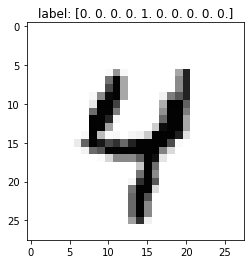

In [4]:
import matplotlib
from matplotlib import pyplot as plt
# static plots
%matplotlib inline 

### show the first data point as an example
n=1111 # test data point number

plt.imshow(test_images[n].reshape(28,28),cmap='Greys')
plt.title('label: {}'.format(test_labels[n]) )

plt.show()

# print the array which generates the image above and expore it!

### SoftMax Regression

Our goal is to train a ML model that classifies the images in the test set, by only using the data in the training set. We will explore shallow and deep networks, as well as fully-connected and convolutional layers.

Instead of learning directly the catecory an imamge falls into, learning is more stable if we model the probability to be in a certain category $i$. To do this, we will use a SoftMax output nonlinearity activaion, which can be thought of as a statistical model that assigns the probability that a given input image corresponds to any of the 10 handwritten digits. This layer is a multi-categorical generalization of the logistic regression and reads as:

$$ 
p\left(y=i|x,\{\boldsymbol{\theta}_k\}_{k=0}^9 \right) = \frac{\exp(x^T\cdot \boldsymbol{\theta}_i)}{\sum_{j=0}^9 \exp(x^T\cdot \boldsymbol{\theta}_j) }
$$

Where  $p\left(y=i|x,\{\boldsymbol{\theta}_k\}_{k=0}^9 \right)$  is the probability that input $x$  is the  $i$-th digit,  $i\in\{0,1,2,\dots,9\}$. The model parameters (sometimes called trainables or learnables) are denoted by $\boldsymbol{\theta}$: in the simplest model, there's one $\theta_j$ per category. One can use this model for prediction by taking that value of $y$ for which the probability is maximized:

$$
y_\mathrm{pred} = \arg\max_{j} p\left(y=j|x,\{\boldsymbol{\theta}_k\}_{k=0}^9 \right).
$$ 

In practice, it is often more convenient to use the logarithm of the softmax function to learn probabilities. Using a log scale allows the model to more easily capture probabilities which differ by several orders of magnitude. Often, there is a special function for this in ML packages, with improved performance. 


### Three ML Models

Below, you have to use the JAX library to build three different models:

A. SoftMax Logistic Regression: no correlations between pixels, no info about image dimensionality

B. DNN: a fully-connected (fc) deep neural network: no info about image dimensionality

C. CNN: a convolutional (conv) neural network with a fully-connected head

### SoftMax Logistic Regression

We begin with the SoftMax Logistic Regression. The code structure will later allow us to easily generalize and re-use the functions we write to the DNN and CNN models. We will proceed in the following steps:

1. Define the ML model. 
2. Define the `loss` function, and a function which measures the `accuracy` of the model predictions. 
3. Define generalized gradient descent optimizer
4. Define the training loop and train the model

Fill-in the code snippet below. To do this, you will have to explore and read the JAX documentation:
* start with [`jax.numpy`](https://jax.readthedocs.io/en/latest/jax.numpy.html) and make yourself familiar with the functions in there. Why is there a need to a JAX version of numpy, i.e. why not use the ordinary numpy library? You may als check out `jax.scipy`.
* look up [`jax.random`](https://jax.readthedocs.io/en/latest/jax.random.html): random numbers work a bit differently in JAX, compared to numpy, but this is not hat important for understanding how to do deep learning in JAX.
* neural network architectures, like the fc and conv layers we will need, are described in [`jax.experimental.stax`](https://jax.readthedocs.io/en/latest/jax.experimental.stax.html); make sure you understand the difference between required/compusory and optional arguments. The [`jax.nn`](https://jax.readthedocs.io/en/latest/jax.nn.html) package contains the nonlinear activation functions. To apply the activations elementwise, use either the [`elementwise` function](https://jax.readthedocs.io/en/latest/_modules/jax/experimental/stax.html#elementwise), or capital-letter activations instead.   


#### Define the ML model

We will first construct the SoftMax model. To do so, we think of it as a single layer NN. To construct the layer, use the `init_fun, apply_fun = stax.serial()` function. This function returns two other functions: `init_fun, apply_fun` (you may give them whatever names you want). 
* `output_shape, params = init_fun(rng, input_shape)` is used to initialize the parameters of the model: it returns the shape of the output at the topmost layer, and a tuple of nested tuples `params` which contains the model parameters. 
* `predictions = predict(params, data)` makes use of the model as defined by `params` and the `data` to apply the model on data and produce the model output. 

Use a subset of the training data which contains, say three, data points. We will use it to debug and explore the model we have defined. 

1.0. build a model consisting of a single `Dense` layer, followed by the `LogSoftMax` activation. 

1.1. compute the model predictions on that toy subset

1.2. check the shape of the output. Does it agree with the `output_shape` tuple returned by `init_fun`?

1.3. print out the prediction values themselves: how many values does each of the three toyset datapoints have? Do these values represent a well-defined probability distribution? -- check the conservation of probability. 

1.4. print the `params` variable and explore it carefully. It defines a so-called JAX tree. Manipulating this ordered list of nested lists can be very annoying if you want to do that from scratch. Instead, explore and use the functions of the [`jax.tree_utils`](https://jax.readthedocs.io/en/latest/jax.tree_util.html) package. Understanding this is especially important if you want to access the parameters of a specific layer in the model. Extract the weights and biases from the single layer model, and check their shape/sizes of the parameters; waht is their data type `type(variable)`; why is this new datatype needed and how can you transfer data from an ordinary numpy datatype to such a datatype back and forth?

In [5]:
import jax.numpy as jnp # jax's numpy version with GPU support
from jax import random # used to define a RNG key to control the random input in JAX
from jax.experimental import stax # neural network library
from jax.experimental.stax import Dense, Relu, LogSoftmax # neural network layers

# set key for the RNG (see JAX docs)
rng = random.PRNGKey(seed)

# cast data into 1D image format suitable for fc layers: the shape should be (N_datapoints, 28*28)
train_images = train_images.reshape(-1,28*28) # -1: number of data points, (28*28): (height*width) dimensions of image
test_images = test_images.reshape(-1,28*28)

# define functions which initialize the parameters and evaluate the model
initialize_params, predict = stax.serial(
                                            ### SoftMax Regression
                                            Dense(10), # 10 output neurons
                                            LogSoftmax # NB: computes the log-probability
    
#                                             ### fully connected DNN
#                                             Dense(512), # 512 hidden neurons
#                                             Relu,
#                                             Dense(256), # 256 hidden neurons
#                                             Relu,
#                                             Dense(10), # 10 output neurons
#                                             LogSoftmax # NB: computes the log-probability
                                        )

# initialize the model parameters
output_shape, inital_params = initialize_params(rng, (-1, 28 * 28)) # fcc layer 28x28 pixes in each image

print('\noutput shape of the model is {}.\n'.format(output_shape))

# check how network works on 3 examples
predictions = predict(inital_params, test_images[0:3])

# print shape of output
print("actual output shape is:", predictions.shape)

# check if probability is conserved
print('log(softmax) values:', predictions[0])
print('conservation of probability', np.sum(jnp.exp(predictions), axis=1))


output shape of the model is (-1, 10).

actual output shape is: (3, 10)
log(softmax) values: [-2.2292223 -2.4820766 -2.7947464 -2.1780825 -1.9830028 -2.2069645
 -1.9345262 -2.6357243 -2.065387  -3.1278682]
conservation of probability [0.9999999 1.0000001 1.0000001]


#### Define the loss/cost function

Next, we define the loss/cost function and the accuracy function to measure the performance of the model. Defining these functions in JAX works the same way as in ordinary python. The only difference is that one has to use `jax.numpy` instead of ordinary `numpy` (for ordinary `numpy` is not optimized for GPUs). 

2.0. Complete the `loss(params, batch)` function which computes the cross entropy, given the model `params` and the data of a minibatch `batch`. Using functions like `jnp.mean` or `jnp.sum` can make the `loss` agnostic to the size of the `batch`. 

2.1. Complete the `mean_accuracy(params, batch)` function. It computes the mean number of datapoints which produce a correct preduction.

2.2. Test the `loss` and `mean_accuracy` functions on the toy dataset. This helps spotting errors and debugging them.

2.3. (optional): use the `tree_flatten` function from the `jax.tree_util` package and add an `L2` regularizer to the `loss` function. To do so, define another function `l2_regularizer(params, lmbda)` which computes the L2 norm of the model parameters and weighs it by the regulazation strength `lmbda`. Is there a JAX function that computes the L2 norm?

2.4. explore the [`jax.grad`](https://jax.readthedocs.io/en/latest/jax.html#jax.grad) function. Test it on the loss function by computing the values of the gradient of the model parameters for the points at the toyset. Check the form of the gradient output. Check the shapes/dimensions of the gradients themselves. 

In [6]:
### define loss and accuracy functions

from jax import grad
from jax.tree_util import tree_flatten # jax params are stored as nested tuples; use this to manipulate tuples


def l2_regularizer(params, lmbda):
    """
    Define l2 regularizer: $\lambda \ sum_j ||theta_j||^2 $ for every parameter in the model $\theta_j$
    
    """
    return lmbda*jnp.sum(jnp.array([jnp.sum(jnp.abs(theta)**2) for theta in tree_flatten(params)[0] ]))


def loss(params, batch):
    """
    Define cost (or lost) function for softmax classification. 
    
    """
    inputs, targets = batch
    preds = predict(params, inputs)
    return -jnp.mean(jnp.sum(preds * targets, axis=1)) + l2_regularizer(params, 0.001)


def mean_accuracy(params, batch):
    """
    Define accuracy function: the mean number of datapoints which have correct preductions. 
    This function is not used for training; only to test the performance. 
    
    """
    inputs, targets = batch
    target_class = jnp.argmax(targets, axis=1)
    predicted_class = jnp.argmax(predict(params, inputs), axis=1)
    return jnp.mean(predicted_class == target_class)

#### Define the optimizer

Next, we define the optimizer. Make sure to read the documentation of [`jax.experimental.optimizers`](https://jax.readthedocs.io/en/latest/jax.experimental.optimizers.html). In particular, you may want to check out the source code for 
[SGD](https://jax.readthedocs.io/en/latest/_modules/jax/experimental/optimizers.html#sgd), 
[SGD with momentum](https://jax.readthedocs.io/en/latest/_modules/jax/experimental/optimizers.html#momentum), and 
[ADAM](https://jax.readthedocs.io/en/latest/_modules/jax/experimental/optimizers.html#adam).

3.0. define the optimizer hyperparameters (step size/learning rate, etc.)

3.1. call the `optimizers.momentum` constructor and obtain the `opt_init, opt_update, get_params` functions. Makes sure you read the documentation to understand what they do, and how they are used.

3.2. Complete the `update(i, opt_state, batch)` function. The only nontrivial step is the the computation of the gradient of the loss function, which we explored in part 2.4. above. Which line does the actual update of the model parameters (e.g. the SGD step) take place in?

3.3. add a `@jit` decorator (Just-In-Time compiler) to the update function. This will make jax compile the `update()` function to give you speed (even on the CPU!). Explore the documentation for [`jax.jit`](https://jax.readthedocs.io/en/latest/jax.html#jax.jit). One caveat is that any functions (and subroutines) used under the `jit` decorator must be using `jax.numpy` or `jax.scipy`; using ordinary `numpy` _and_ `jit` will throw an error (thy that out by modifying the `loss` function!). 

In [7]:
### define generalized gradient descent optimizer and a function to update model parameters

from jax.experimental import optimizers # gradient descent optimizers
from jax import jit

step_size = 0.001 # step size or learning rate 
momentum_mass = 0.9 # "gamma" parameter in GD+momentum

# compute optimizer functions
opt_init, opt_update, get_params = optimizers.momentum(step_size, mass=momentum_mass)


# define function which updates the parameters using the change computed by the optimizer
@jit # Just In Time compilation speeds up the code; requires to use jnp everywhere; remove when debugging
def update(i, opt_state, batch):
    """
    i: int,
        counter to count how many update steps we have performed
    opt_state: object,
        the state of the optimizer
    batch: np.array
        batch containing the data used to update the model
        
    Returns: 
    opt_state: object,
        the new state of the optimizer
        
    """
    # get current parameters of the model
    current_params = get_params(opt_state)
    # compute gradients
    grad_params = grad(loss)(current_params, batch)
    # use the optimizer to perform the update using opt_update
    return opt_update(i, grad_params, opt_state)


#### Train Model

At last, we have built all ingredients and we can start training our model. We train the model in epochs. In every epoch, we loop over the number of minibatches to exhaust the training set. We update the model parameters for each minibatch (hence the number of epochs is not the same of the number of updates). Therefore, we use a variable `itercount` to count the number of updates; in fact, `itercount` will be a trivial generator similar to the ones discussed above. Once we've done the update, we can read off the model parameters and check the current loss and model accuracy ***on the test set*** for the given epoch. 

Then we move to the second epoch and repeat the procedure. The model learns if the loss on the test data goes down, and the accuracy on the test data goes up. We can monitor these quantities durin training.

4.0. define placeholders for the `train_accuracy` and `test_accuracy`. 

4.1. initialize the optimizer state using the `opt_init` function. 

4.2. loop over the epochs. 

4.2.1. For each epoch, loop over all minibatches and use the `update()` function to compute the gradients of the `params` and update the model. Updating the model happens automatically upon calling `update()`. How does `update` know about the current value of `params`? Check if `params` is changing after each call of `update`. 

4.2.2. Compute the mean accuracy of the test and traing data, and store it in `train_accuracy` and `test_accuracy`. Print these values for reference.  

In [8]:
### Train model

import time
import itertools

# define geenrator to count the number of updates
itercount = itertools.count()

# define number of training epochs
num_epochs = 101

# define figures of merit
train_accuracy=np.zeros(num_epochs)
test_accuracy=np.zeros_like(train_accuracy)

print("\nStarting training...\n")

# set the initial model parameters in the optimizer
opt_state = opt_init(inital_params)

# loop over the number of training epochs
for epoch in range(num_epochs): 
    
    ### record time
    start_time = time.time()
    
    ### train in minibatches until the entire dataset is exhausted: 
    # the entire dataset is divided into _random_ minibatches; 
    # all minibatches are shown to the model before going to next epoch
    for _ in range(num_batches):
        # use the data to update the model parameters
        opt_state = update(next(itercount), opt_state, next(batches))
        
    ### record time needed for a single epoch
    epoch_time = time.time() - start_time
    
    ### evaluate performance of the model at each fixed epoch
    
    # retrieve current model parameters
    params = get_params(opt_state)
    
    # measure the accuracy on the training and test datasets
    train_accuracy[epoch] = mean_accuracy(params, (train_images, train_labels))
    test_accuracy[epoch] = mean_accuracy(params, (test_images, test_labels))
    
    # print results every 10 epochs
    if epoch % 10 == 0:
        print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
        print("Training set accuracy {}".format(train_accuracy[epoch]))
        print("Test set accuracy {}\n".format(test_accuracy[epoch]))
        


Starting training...

Epoch 0 in 0.52 sec
Training set accuracy 0.8258500099182129
Test set accuracy 0.8352000117301941

Epoch 10 in 0.10 sec
Training set accuracy 0.8929499983787537
Test set accuracy 0.9003000259399414

Epoch 20 in 0.12 sec
Training set accuracy 0.9025333523750305
Test set accuracy 0.9090999960899353

Epoch 30 in 0.16 sec
Training set accuracy 0.9068499803543091
Test set accuracy 0.9121000170707703

Epoch 40 in 0.13 sec
Training set accuracy 0.9095333218574524
Test set accuracy 0.9143999814987183

Epoch 50 in 0.14 sec
Training set accuracy 0.911466658115387
Test set accuracy 0.9151999950408936

Epoch 60 in 0.10 sec
Training set accuracy 0.912933349609375
Test set accuracy 0.9157999753952026

Epoch 70 in 0.10 sec
Training set accuracy 0.9145166873931885
Test set accuracy 0.916100025177002

Epoch 80 in 0.13 sec
Training set accuracy 0.914900004863739
Test set accuracy 0.9158999919891357

Epoch 90 in 0.10 sec
Training set accuracy 0.9155666828155518
Test set accuracy 0.

#### Explore the training properties and behavior

Below, we compare the training and test average accuracy curves. 

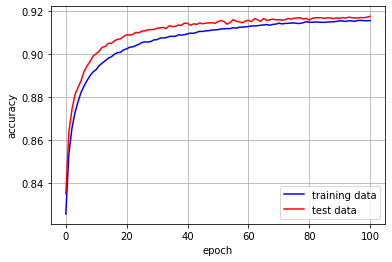

In [14]:
### plot and examine learning curves

epochs=list(range(num_epochs))

plt.plot(epochs, train_accuracy, '-b', label='training data' )
plt.plot(epochs, test_accuracy, '-r', label='test data' )

plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.grid()
plt.legend()
plt.show()

#### Examine the trained Weights

Let's examine the trained weights and check how they look like. This is a first attempt to answer the question what the ML model learns and how it does the classification. 

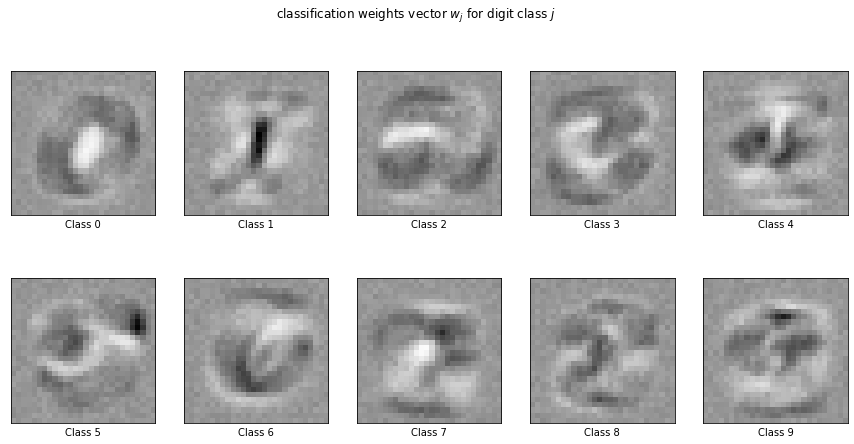

In [10]:
### plot weights vs the pixel position (works only for a single layer)
### code works only SoftMax regression (!)

from jax. tree_util import tree_flatten # jax params are stored as nested tuples; use this to manipulate tuples

# extract weights and biases using tree_flatten
params = get_params(opt_state)
weights, biases  = tree_flatten(params)[0]

# print the weights (biases are not so interesting)
plt.figure(figsize=(15, 7)) # figure size 

scale = np.abs(weights).max() # define overall scale

for i in range(10): # loop over the number of weights
    
    plot = plt.subplot(2, 5, i + 1)
    plot.imshow(weights[:,i].reshape(28, 28), interpolation='nearest', cmap=plt.cm.Greys, vmin=-scale, vmax=scale)
    plot.set_xticks(())
    plot.set_yticks(())
    plot.set_xlabel('Class %i' % i)
    
plt.suptitle('classification weights vector $w_j$ for digit class $j$')

plt.show()

### DNN model

We now want to train a DNN. To do that, all we need to do is add more layers to the model in the `stax.serial()` function, and re-run the training loop. Build a fully-connected DNN model with layer sizes (784, 512, 256, 10), where 784 corresponds to the input layer, and 10 -- to the output layer; i.e. we have two hidden layers. Use a `Relu` nonlinearity after each layer, except for the output where you need the `LogSoftMax`. 


### CNN model

The CNN model is basically the same as the DNN model, except is also uses convolutional layers. Convolutional layers know about the dimensionality of the input. In our case, the data is two-domensional, and thus needs to be reshaped accordingly. Suppose the data had color: in color images each pixel has three values in between [0,255] -- one for each of the red, green, and blue channels. Hence, the dataset is a four-dimensiona array with shape `(N_points, N_Channels, Height, Width)`. For black and white images, we just set `N_Channels=1`.

C.1 reshape the `train_images` and `test_images` to 4-dimensional array. We use the convention `dim_numbers='NCHW'`: (N data points, Channels, Height, Width). 

C.2 use `GeneralConv(dim_numbers, output_channels, filter_size, strides)` layers to add conv layers to the neural net, followed by `Relu` nonlinearities. Add two layers with:
* `output_channels=16, filter_size=(4,4), strides=(4,4)`
* `output_channels=32, filter_size=(3,3), strides=(1,1)`

C.3. Next, we want to attach two dense layers. To be able to do that, we take the output of the last conv layer which has the shape `(N, C, H, W)`, and flatten it to a 1-dimensional array of size `(N, C*H*W)`. Then, we can stack the dense layers, followed by `Relu` nonlinearities each:
* `256` hidden neurals
* `10` output neurons, corresponding to the 10 degit categories.

C.4. Finally, we add the `LogSoftMax` layer. 

C.5. Play with the output of the CNN on the toy dataset to convince yourself you have implemented everything properly. 


The rest of the code we constructed above can be applied without further modification. Why is that so? Do you appreciated now the usefulness of Deep ML packages?

In [11]:
### Convolutional Neural network

from jax.experimental.stax import GeneralConv, Flatten # neural network layers


# cast data into 2D image format
train_images = train_images.reshape(-1,1,28,28) # -1: number of data points, 1: input channels, (28,28) = (height, width) dimensions of image
test_images = test_images.reshape(-1,1,28,28)

# conv net convention
dim_nums=('NCHW', 'OIHW', 'NCHW') # default for (input, filters, output)

# define functions which initialize the parameters and evaluate the model
initialize_params, predict = stax.serial(    
                                            ### convolutional NN (CNN)
                                            GeneralConv(dim_nums, 16, (4,4), strides=(4,4) ), # 16 output channels, (4,4) filter
                                            Relu,
                                            GeneralConv(dim_nums, 32, (3,3), strides=(1,1) ), # 32 output channels, (3,3) filter
                                            Relu,
                                            Flatten, # flatten output
                                            Dense(256), # 256 hidden neurons
                                            Relu,
                                            Dense(10), # 10 output neurons
                                            LogSoftmax # NB: computes the log-probability
                                        )

# initialize the model parameters
output_shape, inital_params = initialize_params(rng, (-1, 1, 28, 28)) # conv layer, 1 input channel, 28x28 pixes in each image

print('\noutput shape of the model is {}.\n'.format(output_shape))

# check how network works on 3 examples
predictions = predict(inital_params, test_images[0:3])

# print shape of output
print("actual output shape is:", predictions.shape)

# check if probability is conserved
print('log(softmax) values:', predictions[0])
print('conservation of probability', np.sum(jnp.exp(predictions), axis=1))


output shape of the model is (-1, 10).

actual output shape is: (3, 10)
log(softmax) values: [-2.264744  -2.4081538 -2.2366066 -2.302778  -2.4543526 -2.3551548
 -2.2510576 -2.1797056 -2.2681572 -2.336163 ]
conservation of probability [0.9999999 1.        1.0000001]


### Further questions

* do you see an advantage of JAX when compared to the other ML packages: TensorFlow or PyTorch? 
* compare the weights plots for the SoftMax regression in the presence of an L2 regularizer added to the cost function. You can use a reguarization strength of `lmbda=0.001`; what happens to the score if you increase/decrease this number? What if you implement an L1 regularizatin instead?
* try and look for the patterns of the imprinted digits in the output weights of the DNN and CNN layers. Explain your findings, and compare them to the SoftMax regression.